In [1]:
% matplotlib inline

In [2]:
import dendropy
import numpy as np
import random
from tree import *
from cfn_noise import create_noisy_dist_matrix
from cfn_noise import measure_epsilon
import matplotlib.pyplot as plt
# import pdb
from mst import prims_mst
# DONE - 1. voting
# DONE - 2. create MST
# IP - 3. valid sampling?
# 4. constraints
# 5. ball growin
# 6. other constraint methods?


In [3]:
# read in strings
# convert to trees and then to matrices
def read_preprocess(tree_file):
    tree_strings = []
    with open(tree_file) as f: #100 trees, each with 10 leaves
        for line in f.readlines():
            tree_strings.append(line)
    dendro_trees = []
    distance_matrices = []
    # find min branch lens for each tree
    min_branch_lens = [float("inf") for _ in range(len(tree_strings))]
    for i in range(len(tree_strings)):
        newick_string = tree_strings[i]
        # get dendropy tree
        tree = dendropy.Tree.get(data=newick_string,schema='newick')
        dendro_trees.append(tree)

        # get min branch length
        for edge in tree.postorder_edge_iter():
            if edge.length:
                min_branch_lens[i] = min(min_branch_lens[i], edge.length)
        # get tree distance matrix 
        tpdm = tree.phylogenetic_distance_matrix()
        num_leaves = len(tree.leaf_nodes()) # for test_trees.txt, these are all the same...
        dist_matrix = np.zeros((num_leaves,num_leaves)) 
        for tax1, tax2 in tpdm.distinct_taxon_pair_iter():
            l1 = int(tax1.label)-1 # for test_trees.txt, nodes are 1-indexed, need to subtract 1
            l2 = int(tax2.label)-1

            dist_matrix[l1,l2] = tpdm.distance(tax1,tax2)
            dist_matrix[l2,l1] = tpdm.distance(tax1,tax2)

        distance_matrices.append(dist_matrix)
    return tree_strings, dendro_trees, distance_matrices, min_branch_lens

In [4]:
# higher order function, takes a matrix, and returns a function that takes 2 PNode leafs and returns distance
# this is to keep the interface functional in case we want to change the process of getting interleaf distances
# for example, computing distances on demand rather than precomputed
def matrix_to_func(matrix):
    def mat_func(i,j):
        # i and j are PNodes. get their values, and dec by 1 (since they are 1-indexed)
        ival,jval = i.get_val()-1,j.get_val()-1
        return matrix[ival,jval]
    return mat_func

In [5]:
def add_noise(dendro_tree, true_matrix, min_branch_len,num_bits_list,scale=None):
    """ add noise to TRUE_MATRIX according to topology in DENDRO_TREE
        using list of ints in NUM_BITS as the number of bits in the mutated bit-string
        and MIN_BRANCH_LEN to measure epsilon, noise
        
        return the list of noisy matrices, and measured epsilon values for them
    """
    noisy_matrices = []
    epsilons = []
    for i in range(len(num_bits_list)):
        noisy_mat = create_noisy_dist_matrix(dendro_tree,num_bits_list[i],scale)
        noisy_matrices.append(noisy_mat)
        epsilons.append(measure_epsilon(true_matrix, noisy_mat, min_branch_len))
    return noisy_matrices,epsilons

In [6]:
from inc import voting_with
def INC(noisy_dist_matrix):
    """
        - Estimate a tree, represented by NOISY_DIST_MATRIX by iteratively inserting leaves into it
        - Use the custom PTree, which uses QUERY_FUNC to search for which edge to break.
            
    """
    # convert matrix to "function" interface
    D = matrix_to_func(noisy_dist_matrix)
    s_node, q_0, ordered_leaves = prims_mst(len(noisy_dist_matrix),D)
    
    # intialize tree
    ptree = PTree(search_fn=voting_with(query, 8*q_0))
    for l in ordered_leaves:
        ptree.insert_leaf(l, D)
    return ptree.make_newick_string()


In [7]:
from ls import local_search_with
def LS(matrix, start_close=True):
    """
        estimate a tree using 'local search', where in each insertion we start at a leaf
        and use node queries until we're told to backtrack.
        
        noisy_dist_matrix - numpy matrix describing interleaf distances
        start_close - for each leaf to insert, start at the already-inserted leaf D-closest to the insert
        return - a newick string of the tree
    """
    D = matrix_to_func(matrix)
    if start_close:
        _,_,insert_order, start_leaf_order = prims_mst(len(matrix),D, True)
    else:
        _, _, insert_order = prims_mst(len(matrix),D)
    ptree = PTree(search_fn=local_search_with(query))
    for i in range(len(insert_order)):
        insert_leaf = insert_order[i]
        start_leaf = None
        if start_close:
            start_leaf = start_leaf_order[i]
        ptree.insert_leaf(insert_order[i], D, start_leaf)
    return ptree.make_newick_string()

In [8]:
from skbio import DistanceMatrix
from skbio.tree import nj

def NJ(matrix):
    """ 
        input: a numpy matrix 
        return: newick string corresponding to neighbor joining
    """
    # one-index the tree for consistency with the input tree
    ids = [str(i) for i in range(1, len(matrix) + 1)]
    dm = DistanceMatrix(matrix, ids)
    newick_str = nj(dm, result_constructor=str)
    return newick_str

In [9]:
def calc_accuracy(noisy_matrix, method, true_tree):
    """ Calculate the accuracy of METHOD on the noisy_matrices, given that
            the true tree structures given in TRUE_TREES iterable
            
        The metric is the true positive rate:
            number of correct nontrivial edges / total true nontrivial edges
        
        METHOD must take a numpy matrix and return a newick string
        """
    
    num_correct = 0 # count the number of nontrivial edges correct
    total = 0 # count to total nontrivial edges

    est_string = method(noisy_matrix)
    est_tree = dendropy.Tree.get(data=est_string,schema='newick')
    # migrate taxon namespace so nodes in each tree are labeled in the same way
    # so that the biparitions later code the same thing
    est_tree.migrate_taxon_namespace(true_tree.taxon_namespace)

    est_cuts = set(est_tree.encode_bipartitions())
    true_cuts = set(true_tree.encode_bipartitions())

    for cut in true_cuts:
        # ignore trivial cuts, which are always shared
        if not cut.is_trivial():
            total += 1
            if cut in est_cuts:
                num_correct += 1
    return num_correct/total

In [10]:
def line_of_best_fit(xs,ys):
    """ Given a list of x values, and their corresponding list of y values.
        Return the slope and bias term"""
    A = np.vstack([xs, np.ones(len(xs))]).T
    m, b = np.linalg.lstsq(A, ys,rcond=None)[0]
    return m,b

# 1 Tree, 10 Leaves, (For debugging/prototyping)

In [11]:
tree_strings, dendro_trees, distance_matrices, min_branch_lens =\
    read_preprocess("/media/sf_constraint_inc/data/trees_10_leaves.txt")
    
tree = dendro_trees[0]
true_mat = distance_matrices[0]
mbl = min_branch_lens[0]
SCALE = 4.5
d,max_ham = create_noisy_dist_matrix(tree,2**9,SCALE,True)
# adjust SCALE so max_ham in [0.4, 0.45]
print(max_ham)
print(measure_epsilon(d, true_mat,mbl))

0.421875
2.3099548217676413


In [12]:
# estimate trees with neighbor joining for different epsilon
nj_accuracies = [] 
ls_accuracies = []
ls_close_accuracies = []
voting_accuracies = []
all_epsilons = []
n = 10
num_bits_list = [int(2**(i/n)) for i in range(9*n,12*n)]
for i in range(1):
    tree = dendro_trees[i]
    mat = distance_matrices[i]
    mbl = min_branch_lens[i]
    noisy_matrices, epsilons = add_noise(tree, mat, mbl,num_bits_list,scale=SCALE)
  
    all_epsilons += epsilons
    for noisy_matrix in noisy_matrices:
        accuracy = calc_accuracy(noisy_matrix, NJ, tree)
        nj_accuracies.append(accuracy)
        accuracy = calc_accuracy(noisy_matrix, lambda x: LS(x, False), tree)
        ls_accuracies.append(accuracy)
        accuracy = calc_accuracy(noisy_matrix, lambda x: LS(x, True), tree)
        ls_close_accuracies.append(accuracy)
        accuracy = calc_accuracy(noisy_matrix, INC,tree)
        voting_accuracies.append(accuracy)



Text(0.5,1,'Accuracy on 10 trees, 10 leaves each')

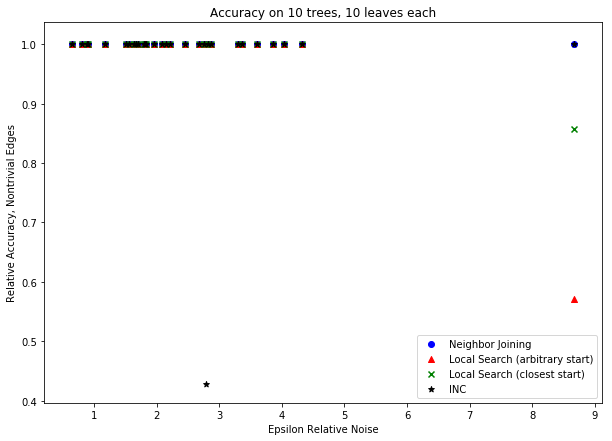

In [13]:
plt.figure(num=1, figsize=(10,7))

p1 = plt.scatter(all_epsilons,nj_accuracies,c='blue',marker='o')
p2 = plt.scatter(all_epsilons,ls_accuracies,c='red',marker='^')
p3 = plt.scatter(all_epsilons,ls_close_accuracies,c='green',marker='x')
p4 = plt.scatter(all_epsilons,voting_accuracies,c='black',marker='*')
# p5 = plt.scatter(all_epsilons,global_ls_accuracies,c='magenta',marker='8')
p1.set_label("Neighbor Joining")
p2.set_label("Local Search (arbitrary start)")
p3.set_label("Local Search (closest start)")
p4.set_label("INC")
# p5.set_label("Local Search (nonrandom leaf choice, ordered insert, global leaf update)")
plt.legend(loc='best')
plt.xlabel("Epsilon Relative Noise")
plt.ylabel("Relative Accuracy, Nontrivial Edges")
# plt.xlim(0,2)
plt.title("Accuracy on 10 trees, 10 leaves each")

# 1 tree, 100 leaves, many replicas


In [14]:
l_tree_strings, l_dendro_trees, l_distance_matrices, l_min_branch_lens =\
    read_preprocess("/media/sf_constraint_inc/data/trees_100_leaves.txt")

In [15]:
# adjust scale so max_ham in [0.4,0.45]
SCALE = 25
d,max_ham = create_noisy_dist_matrix(l_dendro_trees[0],2**14,SCALE,True)
print(max_ham)
print(measure_epsilon(d, l_distance_matrices[0],l_min_branch_lens[0]))

0.408935546875
3.423562599413105


In [16]:
import time
# estimate trees with neighbor joining for different epsilon
l_all_epsilons = []
accuracies_1 = [] 
accuracies_2 = []
accuracies_3 = []
# accuracies_4 = []
# accuracies_5 = []
n = 20
num_bits_list = [int(2**(i/n)) for i in range(8*n,13*n)]
times = [[],[],[],[],[]]
for i in range(1):
    tree = l_dendro_trees[i]
    mat = l_distance_matrices[i]
    mbl = l_min_branch_lens[i]
    noisy_matrices, epsilons = add_noise(tree, mat, mbl,num_bits_list,scale=SCALE)
  
    l_all_epsilons += epsilons
    for noisy_matrix in noisy_matrices:
        print(i,end='.')
        i += 1
        
        t = time.time()
        accuracy = calc_accuracy(noisy_matrix, NJ, tree)
        times[0].append(time.time() - t)
        accuracies_1.append(accuracy)
        
        t = time.time()
        accuracy = calc_accuracy(noisy_matrix, INC, tree)
        times[1].append(time.time() - t)
        accuracies_2.append(accuracy)
        
        t = time.time()
        accuracy = calc_accuracy(noisy_matrix,lambda x: LS(x,True), tree)
        times[2].append(time.time() - t)  
        accuracies_3.append(accuracy)  

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.

Neighbor Joining average time: 2.32487500667572
INC (with tie-breaking rounds) average time: 0.12704798460006714
Local Search (starting from closest leaf) average time: 0.03153846025466919


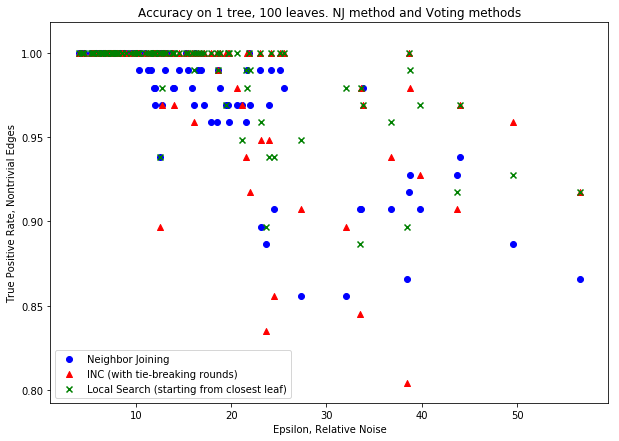

In [17]:
plt.figure(num=2, figsize=(10,7))
p1 = plt.scatter(l_all_epsilons,accuracies_1,c='blue',marker='o')
p2 = plt.scatter(l_all_epsilons,accuracies_2,c='red',marker='^')
p3 = plt.scatter(l_all_epsilons,accuracies_3,c='green',marker='x')
# p4 = plt.scatter(l_all_epsilons,accuracies_4,c='black',marker='*')
# p5 = plt.scatter(l_all_epsilons,accuracies_5,c='magenta',marker='8')
titles = ["Neighbor Joining",
          "INC (with tie-breaking rounds)",
          "Local Search (starting from closest leaf)"]
FIGURE_TITLE = "Accuracy on 1 tree, 100 leaves. NJ method and Voting methods"
p1.set_label(titles[0])
p2.set_label(titles[1])
p3.set_label(titles[2])
# p4.set_label(titles[3])
# p5.set_label(titles[4])
plt.legend(loc='best')
plt.xlabel("Epsilon, Relative Noise")
plt.ylabel("True Positive Rate, Nontrivial Edges")
# plt.xlim(0,2)
plt.title(FIGURE_TITLE)

m1,c1 = line_of_best_fit(l_all_epsilons,accuracies_1)
m2,c2 = line_of_best_fit(l_all_epsilons,accuracies_2)
m3,c3 = line_of_best_fit(l_all_epsilons,accuracies_3)
# m4,c4 = line_of_best_fit(l_all_epsilons,accuracies_4)
# m5,c5 = line_of_best_fit(l_all_epsilons,accuracies_5)
xs = np.array(l_all_epsilons)
# plt.figure(num=3, figsize=(10,7))
# plt.plot(xs, m1*xs + c1, 'blue', label='{0} Fitted Line'.format(titles[0]))
# plt.plot(xs, m2*xs + c2, 'red',  label='{0} Fitted Line'.format(titles[1]))
# plt.plot(xs, m3*xs + c3, 'green', label='{0} Fitted Line'.format(titles[2]))
# plt.plot(xs, m4*xs + c4, 'black', label='{0} Fitted Line'.format(titles[3]))
# plt.plot(xs, m5*xs + c5, 'magenta', label='{0} Fitted Line'.format(titles[4]))

print("{0} average time: {1}".format(titles[0], sum(times[0])/len(times[0])))
print("{0} average time: {1}".format(titles[1], sum(times[1])/len(times[1])))
print("{0} average time: {1}".format(titles[2], sum(times[2])/len(times[2])))
